In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress,norm
from scipy import integrate

1\. **Color-coded scatter plot**

Produce a scatter plot from a dataset with two categories.

* Write a function that generates a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and standard deviation. Set different values of the mean and stardand deviation between the two samples.
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below:

In [ ]:
from IPython.display import Image
Image('two_categories_scatter_plot.png')

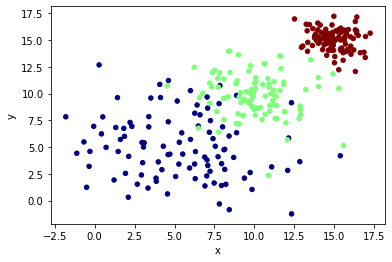

In [55]:
def create_dataset(num_samples, m, std):
  """
    create datasets with 
      num_samples : number of samples
      m : array of mean
      std : array of standard deviation
    return dataframe 
  """
  val = np.zeros((0,len(m)))
  for i in range(len(m)):
      mean = np.ones((2)) * m[i]
      cov_mat = np.eye(2) * std[i]
      dist = np.random.multivariate_normal(mean, cov_mat, size = num_samples)
      cat_dist = np.concatenate([dist, np.ones((num_samples, 1))*i/len(m)], axis = 1)
      val = np.concatenate([val,cat_dist], axis = 0)
  return pd.DataFrame(val, columns = ["x", "y","Cat"]) 
mean = [5.0, 10.0, 15.0]
var = [10.0, 5.0, 1.0]
num_samples = 100
df = create_dataset(num_samples, mean, var)
df.plot.scatter("x", "y", c = "Cat", cmap='jet', colorbar = False,)

2\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following pickle file:
```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```
* Inspect the dataset, you'll find two variables (features)
* Convert the content to a Pandas Dataframe
* Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
* Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 

Comment on the correlation between these variables.

* Create manually (without using seaborn) the profile histogram for the "distance" variable; choose an appropriate binning.
* Obtain 3 numpy arrays:
  * `x`, the array of bin centers of the profile histogram of the "distance" variable
  * `y`, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * `err_y`, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [ ]:
!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/

In [57]:
file = "./data/residuals_261.pkl"
df = pd.DataFrame(pd.read_pickle(file).item())

In [58]:
df = df[abs(df["residuals"]) < 2]
df

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


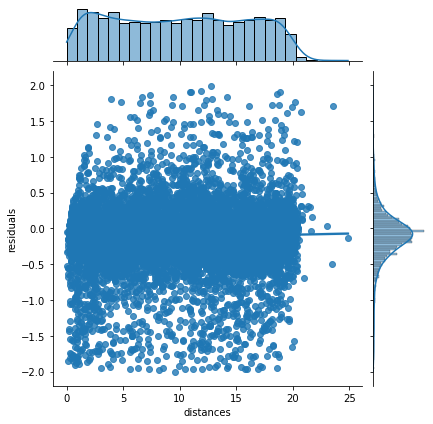

In [59]:
sns.jointplot(x="distances", y="residuals", data=df, kind="reg")

In [71]:
_, bin_edges = np.histogram(df["distances"], bins = 25)
intervals, _ = pd.cut(df["distances"], bin_edges, retbins = True)
x = bin_edges[:-1] + np.diff(bin_edges)/2
mid = intervals.map(lambda x: (x.right + x.left)/2)
df["mid"] = mid
grouped = df.groupby("mid")
y = grouped["residuals"].mean()
err = grouped["residuals"].std()

Text(0, 0.5, 'Residuals')

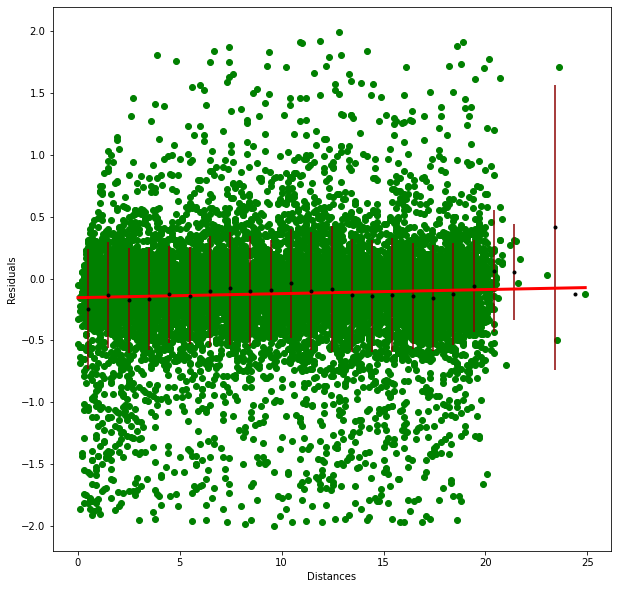

In [75]:
slope, intercept, r_value, p_value, std_err = linregress(df["distances"], df["residuals"])
plt.figure(figsize=(10,10))
plt.scatter(df["distances"], df["residuals"], c  ="green")
var = bin_edges
val = slope * bin_edges + intercept
concat = np.concatenate([var[:, np.newaxis], val[:, np.newaxis]], axis = 1)
d =  pd.DataFrame(concat, columns = ["variable", "value"])
plt.plot(var, val, c = "red",linewidth=3)
plt.errorbar(x, y, yerr = err, fmt = ".", c = "black", ecolor='darkred')
plt.xlabel("Distances")
plt.ylabel("Residuals")

3\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn):

* Fill a numpy array `x` of length N (with $N=\mathcal{O}(100)$) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking proper care of the aesthetic:
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* For every element of `x`, create a gaussian with the mean corresponding to the element value and the standard deviation as a parameter that can be tuned. The standard deviation default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method. Superimpose the normalized sum of all gaussians to the first histogram.


In [128]:
N=100
m = 5
std = 3.0
x = np.random.normal(loc=m, scale=std, size=N,)

Integral:  79.9150960457071
Histogram:  82.15024671509441


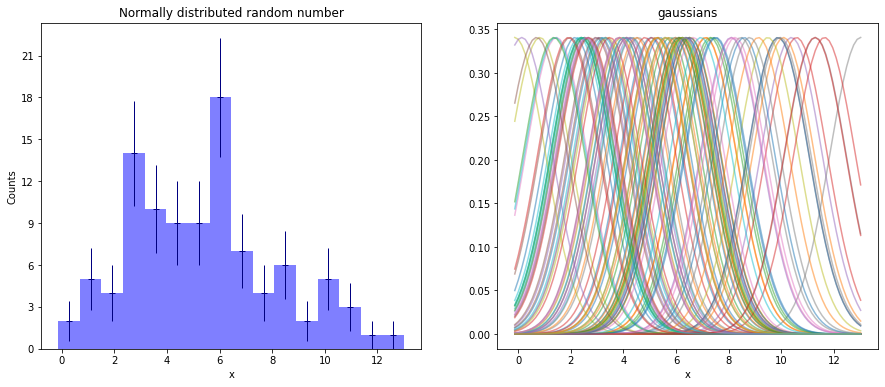

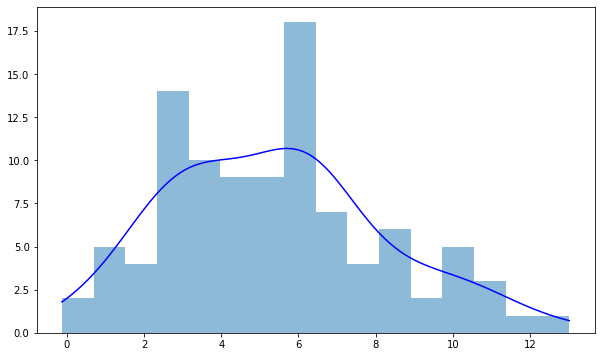

In [155]:
nbins = int(1 + 3.322*np.log(N))

fig, ax = plt.subplots(ncols=2,figsize=(15, 6))
h, bins, _ = ax[0].hist(x, bins=nbins, color='blue', alpha=0.5)
ax[0].set_title('Normally distributed random number')
ax[0].set_xlabel("x")
ax[0].set_ylabel("Counts")
ax[0].yaxis.set_major_locator(MaxNLocator(integer=True)) #Restrict ticks to integer
x_bins = bins[:-1]+ 0.5*(bins[1:] - bins[:-1])
ax[0].errorbar(x_bins, h, yerr=np.sqrt(h), c="navy",fmt="+",elinewidth=1)

#gaussians
g_x = np.linspace(x.min(), x.max(), 100)
g_sigma = 1.06*np.std(x)*x.size**(-1/5)
gaus = []

for m in x:
    g_y = norm.pdf(g_x, m, g_sigma)
    gaus.append(g_y)
    ax[1].plot(g_x,g_y, alpha=0.5)
ax[1].set_title("gaussians")
ax[1].set_xlabel("x")


gaus = np.array(gaus)
s = np.sum(gaus, axis=0)
step = bins[1] - bins[0]
print("Integral: ", integrate.trapz(s*step, g_x))
print("Histogram: ", np.sum(step*h))
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(g_x, s*step, '-b')
_=ax.hist(x, bins=nbins, alpha = 0.5)